In [1]:
import pandas as pd
import datetime

import warnings
warnings.filterwarnings('ignore')

## Prepare data

In [2]:
df = pd.read_csv('data_clean.csv')
df['date'] = df['date'].astype('datetime64[ns]')

atms = list(df.atm_name.unique())

In [3]:
threshold = datetime.datetime.strptime('2016-12-09', '%Y-%m-%d')

train = df[df['date'] <= threshold]
test = df[df['date'] > threshold]

In [4]:
test['amount_total'].std()

286356.4964370119

## All days mean per ATM

In [5]:
def get_mean(day, month, atm):
    return train[
        (train['atm_name'] == atm)&\
        (train['date'].dt.day == day)&\
        (train['date'].dt.month == month)
    ].amount_total.mean()

In [6]:
test['predict'] = test.apply(lambda row: get_mean(row.date.day, row.date.month, row['atm_name']), axis=1)

In [7]:
# RMSE
(((test['amount_total'] - test['predict']) ** 2) ** 0.5).mean()

221132.3022300397

## Mean over last 9 weeks per atm

In [8]:
def get_mean_nweeks(day, atm, weeks):
    return df[
        (df['date'] >= day - datetime.timedelta(days=weeks * 7))&
        (df['date'] < day)&
        (df['date'].dt.weekday == day.weekday())&
        (df['atm_name'] == atm)
    ].amount_total.mean()

In [9]:
test['predict'] = test.apply(lambda row: get_mean_nweeks(row['date'], row['atm_name'], 13), axis=1)

# RMSE
(((test['amount_total'] - test['predict']) ** 2) ** 0.5).mean()

189043.86643743914

In [10]:
dist = []
for week in range(1,52):
    test['predict'] = test.apply(lambda row: get_mean_nweeks(row['date'], row['atm_name'], week), axis=1)
    
    dist.append({'weeks': week,
     'RMSE': (((test['amount_total'] - test['predict']) ** 2) ** 0.5).mean()
    })

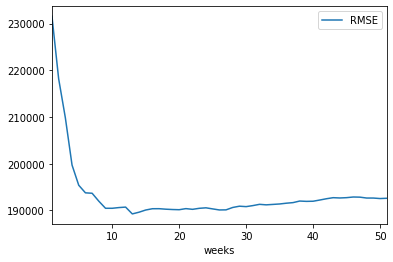

In [176]:
pd.DataFrame(dist).set_index('weeks').plot()

## Prophet

In [11]:
from fbprophet import Prophet

In [41]:
predicts = pd.DataFrame(None)

for atm in atms:
    m = Prophet()
    
    train_atm = train[train['atm_name'] == atm][['amount_total', 'date']]
    train_atm.columns = ['y', 'ds']
    m.fit(train_atm)
            
    future = m.make_future_dataframe(periods=365)
    predict = m.predict(future)
    predict = predict[['ds', 'yhat']]
    predict['atm_name'] = atm
    
    predicts = predicts.append(predict.iloc[-365:])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [49]:
test = test.set_index(['date', 'atm_name']).join(predicts)

In [50]:
# RMSE
(((test['amount_total'] - test['yhat']) ** 2) ** 0.5).mean()

227472.40299344595